# Particle Lenia [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/maxencefaldor/cax/blob/main/examples/22_particle_lenia.ipynb)

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX with:

In [ ]:
%pip install -U "jax[cuda12]"

Then, install CAX from PyPi:

In [ ]:
%pip install -U "cax[examples]"

## Import

In [ ]:
import jax

In [1]:
# @title (imports & utils)
import base64
import io
import subprocess
import time
from collections import namedtuple
from functools import partial

import ipywidgets as widgets
import jax.numpy as jp
import matplotlib.pylab as pl
import numpy as np
import PIL
from IPython.display import HTML, Image, clear_output, display


def np2pil(a):
	if a.dtype in [np.float32, np.float64]:
		a = np.uint8(np.clip(a, 0, 1) * 255)
	return PIL.Image.fromarray(a)


def imwrite(f, a, fmt=None):
	a = np.asarray(a)
	if isinstance(f, str):
		fmt = f.rsplit(".", 1)[-1].lower()
		if fmt == "jpg":
			fmt = "jpeg"
		f = open(f, "wb")
	np2pil(a).save(f, fmt, quality=95)


def imencode(a, fmt="jpeg"):
	a = np.asarray(a)
	if len(a.shape) == 3 and a.shape[-1] == 4:
		fmt = "png"
	f = io.BytesIO()
	imwrite(f, a, fmt)
	return f.getvalue()


def imshow(a, fmt="jpeg", display=display):
	return display(Image(data=imencode(a, fmt)))


def grab_plot(close=True):
	"""Return the current Matplotlib figure as an image"""
	fig = pl.gcf()
	fig.canvas.draw()
	img = np.array(fig.canvas.renderer._renderer)
	a = np.float32(img[..., 3:] / 255.0)
	img = np.uint8(255 * (1.0 - a) + img[..., :3] * a)  # alpha
	if close:
		pl.close()
	return img


def show_videofile(fn):
	b64 = base64.b64encode(open(fn, "rb").read()).decode("utf8")
	s = f"""<video controls loop>
 <source src="data:video/mp4;base64,{b64}" type="video/mp4">
 Your browser does not support the video tag.</video>"""
	display(HTML(s))


class VideoWriter:
	def __init__(self, filename="_tmp.mp4", fps=30.0, show_on_finish=True):
		self.ffmpeg = None
		self.filename = filename
		self.fps = fps
		self.view = widgets.Output()
		self.last_preview_time = 0.0
		self.frame_count = 0
		self.show_on_finish = show_on_finish
		display(self.view)

	def add(self, img):
		img = np.asarray(img)
		h, w = img.shape[:2]
		if self.ffmpeg is None:
			self.ffmpeg = self._open(w, h)
		if img.dtype in [np.float32, np.float64]:
			img = np.uint8(img.clip(0, 1) * 255)
		if len(img.shape) == 2:
			img = np.repeat(img[..., None], 3, -1)
		self.ffmpeg.stdin.write(img.tobytes())
		t = time.time()
		self.frame_count += 1
		if self.view and t - self.last_preview_time > 1.0:
			self.last_preview_time = t
			with self.view:
				clear_output(wait=True)
				imshow(img)
				print(self.frame_count)

	def __call__(self, img):
		return self.add(img)

	def _open(self, w, h):
		cmd = f"""ffmpeg -y -f rawvideo -vcodec rawvideo -s {w}x{h}
      -pix_fmt rgb24 -r {self.fps} -i - -pix_fmt yuv420p
      -c:v libx264 -crf 20 {self.filename}""".split()
		return subprocess.Popen(cmd, stdin=subprocess.PIPE, stderr=subprocess.PIPE)

	def close(self):
		if self.ffmpeg:
			self.ffmpeg.stdin.close()
			self.ffmpeg.wait()
			self.ffmpeg = None
		if self.view:
			with self.view:
				clear_output()
			self.view.close()
			self.view = None

	def __enter__(self):
		return self

	def __exit__(self, *kw):
		self.close()
		if self.show_on_finish:
			self.show()

	def _ipython_display_(self):
		self.show()

	def show(self):
		self.close()
		show_videofile(self.filename)


# JAX utils


def vmap2(f):
	return jax.vmap(jax.vmap(f))


def norm(v, axis=-1, keepdims=False, eps=0.0):
	return jp.sqrt((v * v).sum(axis, keepdims=keepdims).clip(eps))


def normalize(v, axis=-1, eps=1e-20):
	return v / norm(v, axis, keepdims=True, eps=eps)


pl.rcParams.update({"axes.grid": True})

# Particle Lenia and the energy-based formulation

Authors | Affiliation | Published
--------|-------------|----------
[Alexander Mordvintsev](https://znah.net) | [Google](https://ai.google/) | December 23, 2022
[Eyvind Niklasson](https://eyvind.me/) | |
[Ettore Randazzo](https://oteret.github.io/) | | <a href="https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/particle_lenia.ipynb" target="_blank" id="colablink" class="colab-root"><span id="reprotext">Reproduce in </span><span class="colab-span">Notebook</span></a><a id="arxiv" title="ETA Q1 2023" href="about:blank" target="_blank" class="colab-root"><span class="arxiv-span"></span></a>

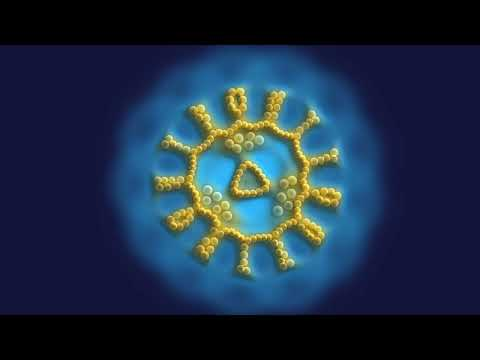

In [2]:
# @title (intro video)
from IPython.display import YouTubeVideo

YouTubeVideo("AP3zeHyWakw", width=800, height=450)

<p id="pdemo">
<a id="demo" href="https://znah.net/lenia" target="_blank" class="colab-root">DEMO 🔬👾</a><br><br>
</p>

[TOC]

## Introduction

Patterns and behaviors you see in the video above were produced by the artificial life system that we called “Particle Lenia”. It’s inspired by [Lenia Mathematical Lifeforms](https://chakazul.github.io/lenia.html), which in turn is a continuous generalization of John Conway's [Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life). In this article we are going to describe the motivation, implementation and behavior of Particle Lenia.

Before diving into the details of the proposed model, we would like to speculate a little about why to create such models. Physics, chemistry and biology study the organization of matter at various scales, from subatomic to cosmic. The behavior of each scale is determined by the laws that govern behavior of the underlying scale, but the nature of relations between scales is full of surprises. For example let’s consider a simple idea: matter consists of tiny, constantly moving particles, which attract each other at close distances, but repel when they are too close. [Lennard-Jones potential](https://en.wikipedia.org/wiki/Lennard-Jones_potential) is one of possible mathematical formalizations of the above idea. In spite of the apparent simplicity of microscopic dynamics, at large scales these rules give rise to a plethora of complex phenomena, such as aggregate states of matter, thermodynamics, acoustics, hydrodynamics and turbulence. In scientific and engineering practice we can often abstract microscopic details behind macroscopic models, such as diffusion or Navier-Stokes equations, that operate at the scale of interest. But in some domains, like material science or biochemistry, we have to focus on the relationship between many orders of magnitude in scale. How do changes in molecular structure reflect in macroscopic material properties? How do genomic sequences translate into morphological appearance? In the field of biology these ties between scales are especially important and obscure at the same time. That’s why development of practical methods of capturing and analyzing such relations are of a great need. *In silico* multi-agent models provide a computational playground for creation and improvement of such methods. We may use such models for efficient design of local microscopic rules that lead to a desired global behavior. Thus, creation of simulated Artificial Life serves as a stepping stone in deep understanding of life in the real world.

[Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) cellular automata captivated the attention of a few generations of researchers and hobbyists with a diversity of complex behaviors stemming from a very simple set of local rules. A few continuous generalizations were proposed, [SmoothLife](https://www.youtube.com/watch?v=8wDSQxmAyTw) and [Lenia](https://chakazul.github.io/lenia.html) are most popular among them. They describe evolution of one or a few scalar fields with a system of PDEs. Such models can support a great diversity of interesting and beautiful life-like behaviors. Yet we argue that PDE-based models have a couple of drawbacks, which motivated the creation of the particle based analogy.

In [3]:
# @title (OG Lenia creatures diagram)
# based on Bert Chan's original Lenia implementation
# https://colab.research.google.com/github/Chakazul/Lenia/blob/master/Jupyter/Lenia.ipynb


class Lenia(namedtuple("Lenia", "R, peaks, mu, sigma")):
	def rescale(p, x, n=4):
		x = jp.repeat(jp.repeat(jp.array(x), n, axis=0), n, axis=1)
		p = p._replace(R=p.R * n)
		return p, x

	def kernel_shell(p, r):
		def kernel_core(r):
			rm = jp.minimum(r, 1)
			return (4 * rm * (1 - rm)) ** 4

		k = len(p.peaks)
		kr = k * r
		peak = p.peaks[jp.minimum(jp.floor(kr).astype(int), k - 1)]
		return (r < 1) * kernel_core(kr % 1) * peak

	@jax.jit
	def step(p, x, dt=0.05):
		SIZE = x.shape[0]
		MID = SIZE // 2
		I = jp.array(
			[
				jp.arange(SIZE),
			]
			* SIZE
		)
		X = (I - MID) / p.R
		Y = X.T
		D = jp.sqrt(X**2 + Y**2)

		kernel = p.kernel_shell(D)
		kernel_FFT = jp.fft.fft2(kernel / jp.sum(kernel))
		x_FFT = jp.fft.fft2(x)
		potential = jp.roll(jp.real(jp.fft.ifft2(kernel_FFT * x_FFT)), MID, (0, 1))
		delta = jp.maximum(0, 1 - (potential - p.mu) ** 2 / (p.sigma**2 * 9)) ** 4 * 2 - 1
		return jp.maximum(0, jp.minimum(1, x + delta * dt))

	@staticmethod
	def render_world(
		x, vmin=0, vmax=1, title_1="", title_2="", sep_x=None, alpha_1=1.0, alpha_2=1.0
	):
		SIZE = x.shape[0]
		if sep_x is None:
			sep_x = SIZE
		fig = pl.figure(figsize=(jp.shape(x)[1] / 80, jp.shape(x)[0] / 80), dpi=80)
		ax = fig.add_axes([0, 0, 1, 1])
		ax.grid(False)
		ax.text(
			sep_x // 2,
			SIZE - 40,
			title_1,
			fontsize="xx-large",
			color="white",
			ha="center",
			va="center",
			alpha=alpha_1,
		)
		ax.text(
			SIZE + sep_x // 2,
			SIZE - 40,
			title_2,
			fontsize="xx-large",
			color="white",
			ha="center",
			va="center",
			alpha=alpha_2,
		)
		ax.axvline(x=sep_x, linestyle="--", linewidth=4)
		img = ax.imshow(x, cmap="jet", interpolation="none", aspect=1, vmin=vmin, vmax=vmax)
		return grab_plot()

	@staticmethod
	def get_creatures():
		p1 = Lenia(R=13, peaks=jp.array([1]), mu=0.15, sigma=0.014)
		p2 = Lenia(R=13, peaks=jp.array([1]), mu=0.156, sigma=0.0224)
		c1 = jp.array(
			[
				[0, 0, 0, 0, 0, 0, 0.1, 0.14, 0.1, 0, 0, 0.03, 0.03, 0, 0, 0.3, 0, 0, 0, 0],
				[
					0,
					0,
					0,
					0,
					0,
					0.08,
					0.24,
					0.3,
					0.3,
					0.18,
					0.14,
					0.15,
					0.16,
					0.15,
					0.09,
					0.2,
					0,
					0,
					0,
					0,
				],
				[
					0,
					0,
					0,
					0,
					0,
					0.15,
					0.34,
					0.44,
					0.46,
					0.38,
					0.18,
					0.14,
					0.11,
					0.13,
					0.19,
					0.18,
					0.45,
					0,
					0,
					0,
				],
				[
					0,
					0,
					0,
					0,
					0.06,
					0.13,
					0.39,
					0.5,
					0.5,
					0.37,
					0.06,
					0,
					0,
					0,
					0.02,
					0.16,
					0.68,
					0,
					0,
					0,
				],
				[
					0,
					0,
					0,
					0.11,
					0.17,
					0.17,
					0.33,
					0.4,
					0.38,
					0.28,
					0.14,
					0,
					0,
					0,
					0,
					0,
					0.18,
					0.42,
					0,
					0,
				],
				[
					0,
					0,
					0.09,
					0.18,
					0.13,
					0.06,
					0.08,
					0.26,
					0.32,
					0.32,
					0.27,
					0,
					0,
					0,
					0,
					0,
					0,
					0.82,
					0,
					0,
				],
				[
					0.27,
					0,
					0.16,
					0.12,
					0,
					0,
					0,
					0.25,
					0.38,
					0.44,
					0.45,
					0.34,
					0,
					0,
					0,
					0,
					0,
					0.22,
					0.17,
					0,
				],
				[
					0,
					0.07,
					0.2,
					0.02,
					0,
					0,
					0,
					0.31,
					0.48,
					0.57,
					0.6,
					0.57,
					0,
					0,
					0,
					0,
					0,
					0,
					0.49,
					0,
				],
				[
					0,
					0.59,
					0.19,
					0,
					0,
					0,
					0,
					0.2,
					0.57,
					0.69,
					0.76,
					0.76,
					0.49,
					0,
					0,
					0,
					0,
					0,
					0.36,
					0,
				],
				[
					0,
					0.58,
					0.19,
					0,
					0,
					0,
					0,
					0,
					0.67,
					0.83,
					0.9,
					0.92,
					0.87,
					0.12,
					0,
					0,
					0,
					0,
					0.22,
					0.07,
				],
				[0, 0, 0.46, 0, 0, 0, 0, 0, 0.7, 0.93, 1, 1, 1, 0.61, 0, 0, 0, 0, 0.18, 0.11],
				[0, 0, 0.82, 0, 0, 0, 0, 0, 0.47, 1, 1, 0.98, 1, 0.96, 0.27, 0, 0, 0, 0.19, 0.1],
				[
					0,
					0,
					0.46,
					0,
					0,
					0,
					0,
					0,
					0.25,
					1,
					1,
					0.84,
					0.92,
					0.97,
					0.54,
					0.14,
					0.04,
					0.1,
					0.21,
					0.05,
				],
				[
					0,
					0,
					0,
					0.4,
					0,
					0,
					0,
					0,
					0.09,
					0.8,
					1,
					0.82,
					0.8,
					0.85,
					0.63,
					0.31,
					0.18,
					0.19,
					0.2,
					0.01,
				],
				[
					0,
					0,
					0,
					0.36,
					0.1,
					0,
					0,
					0,
					0.05,
					0.54,
					0.86,
					0.79,
					0.74,
					0.72,
					0.6,
					0.39,
					0.28,
					0.24,
					0.13,
					0,
				],
				[
					0,
					0,
					0,
					0.01,
					0.3,
					0.07,
					0,
					0,
					0.08,
					0.36,
					0.64,
					0.7,
					0.64,
					0.6,
					0.51,
					0.39,
					0.29,
					0.19,
					0.04,
					0,
				],
				[
					0,
					0,
					0,
					0,
					0.1,
					0.24,
					0.14,
					0.1,
					0.15,
					0.29,
					0.45,
					0.53,
					0.52,
					0.46,
					0.4,
					0.31,
					0.21,
					0.08,
					0,
					0,
				],
				[
					0,
					0,
					0,
					0,
					0,
					0.08,
					0.21,
					0.21,
					0.22,
					0.29,
					0.36,
					0.39,
					0.37,
					0.33,
					0.26,
					0.18,
					0.09,
					0,
					0,
					0,
				],
				[
					0,
					0,
					0,
					0,
					0,
					0,
					0.03,
					0.13,
					0.19,
					0.22,
					0.24,
					0.24,
					0.23,
					0.18,
					0.13,
					0.05,
					0,
					0,
					0,
					0,
				],
				[0, 0, 0, 0, 0, 0, 0, 0, 0.02, 0.06, 0.08, 0.09, 0.07, 0.05, 0.01, 0, 0, 0, 0, 0],
			]
		)
		c2 = jp.array(
			[
				[0, 0, 0, 0, 0, 0, 0, 0, 0.003978, 0.016492, 0.004714, 0, 0, 0, 0, 0, 0, 0, 0, 0],
				[
					0,
					0,
					0,
					0,
					0,
					0.045386,
					0.351517,
					0.417829,
					0.367137,
					0.37766,
					0.426948,
					0.431058,
					0.282864,
					0.081247,
					0,
					0,
					0,
					0,
					0,
					0,
				],
				[
					0,
					0,
					0,
					0,
					0.325473,
					0.450995,
					0.121737,
					0,
					0,
					0,
					0.003113,
					0.224278,
					0.47101,
					0.456459,
					0.247231,
					0.071609,
					0.013126,
					0,
					0,
					0,
				],
				[
					0,
					0,
					0,
					0.386337,
					0.454077,
					0,
					0,
					0,
					0,
					0,
					0,
					0,
					0.27848,
					0.524466,
					0.464281,
					0.242651,
					0.096721,
					0.038476,
					0,
					0,
				],
				[
					0,
					0,
					0.258817,
					0.583802,
					0.150994,
					0,
					0,
					0,
					0,
					0,
					0,
					0,
					0.226639,
					0.548329,
					0.550422,
					0.334764,
					0.153108,
					0.087049,
					0.042872,
					0,
				],
				[
					0,
					0.008021,
					0.502406,
					0.524042,
					0.059531,
					0,
					0,
					0,
					0,
					0,
					0,
					0.033946,
					0.378866,
					0.615467,
					0.577527,
					0.357306,
					0.152872,
					0.090425,
					0.058275,
					0.023345,
				],
				[
					0,
					0.179756,
					0.596317,
					0.533619,
					0.162612,
					0,
					0,
					0,
					0,
					0.015021,
					0.107673,
					0.325125,
					0.594765,
					0.682434,
					0.594688,
					0.381172,
					0.152078,
					0.073544,
					0.054424,
					0.030592,
				],
				[
					0,
					0.266078,
					0.614339,
					0.605474,
					0.379255,
					0.195176,
					0.16516,
					0.179148,
					0.204498,
					0.299535,
					0.760743,
					1,
					1,
					1,
					1,
					0.490799,
					0.237826,
					0.069989,
					0.043549,
					0.022165,
				],
				[
					0,
					0.333031,
					0.64057,
					0.686886,
					0.60698,
					0.509866,
					0.450525,
					0.389552,
					0.434978,
					0.859115,
					0.94097,
					1,
					1,
					1,
					1,
					1,
					0.747866,
					0.118317,
					0.037712,
					0.006271,
				],
				[
					0,
					0.417887,
					0.6856,
					0.805342,
					0.824229,
					0.771553,
					0.69251,
					0.614328,
					0.651704,
					0.843665,
					0.910114,
					1,
					1,
					0.81765,
					0.703404,
					0.858469,
					1,
					0.613961,
					0.035691,
					0,
				],
				[
					0.04674,
					0.526827,
					0.787644,
					0.895984,
					0.734214,
					0.661746,
					0.670024,
					0.646184,
					0.69904,
					0.723163,
					0.682438,
					0.618645,
					0.589858,
					0.374017,
					0.30658,
					0.404027,
					0.746403,
					0.852551,
					0.031459,
					0,
				],
				[
					0.130727,
					0.658494,
					0.899652,
					0.508352,
					0.065875,
					0.009245,
					0.232702,
					0.419661,
					0.461988,
					0.470213,
					0.390198,
					0.007773,
					0,
					0.010182,
					0.080666,
					0.17231,
					0.44588,
					0.819878,
					0.034815,
					0,
				],
				[
					0.198532,
					0.810417,
					0.63725,
					0.031385,
					0,
					0,
					0,
					0,
					0.315842,
					0.319248,
					0.321024,
					0,
					0,
					0,
					0,
					0.021482,
					0.27315,
					0.747039,
					0,
					0,
				],
				[
					0.217619,
					0.968727,
					0.104843,
					0,
					0,
					0,
					0,
					0,
					0.152033,
					0.158413,
					0.114036,
					0,
					0,
					0,
					0,
					0,
					0.224751,
					0.647423,
					0,
					0,
				],
				[
					0.138866,
					1,
					0.093672,
					0,
					0,
					0,
					0,
					0,
					0.000052,
					0.015966,
					0,
					0,
					0,
					0,
					0,
					0,
					0.281471,
					0.455713,
					0,
					0,
				],
				[
					0,
					1,
					0.145606,
					0.005319,
					0,
					0,
					0,
					0,
					0,
					0,
					0,
					0,
					0,
					0,
					0,
					0.016878,
					0.381439,
					0.173336,
					0,
					0,
				],
				[
					0,
					0.97421,
					0.262735,
					0.096478,
					0,
					0,
					0,
					0,
					0,
					0,
					0,
					0,
					0,
					0,
					0.013827,
					0.217967,
					0.287352,
					0,
					0,
					0,
				],
				[
					0,
					0.593133,
					0.2981,
					0.251901,
					0.167326,
					0.088798,
					0.041468,
					0.013086,
					0.002207,
					0.009404,
					0.032743,
					0.061718,
					0.102995,
					0.1595,
					0.24721,
					0.233961,
					0.002389,
					0,
					0,
					0,
				],
				[
					0,
					0,
					0.610166,
					0.15545,
					0.200204,
					0.228209,
					0.241863,
					0.243451,
					0.270572,
					0.446258,
					0.376504,
					0.174319,
					0.154149,
					0.12061,
					0.074709,
					0,
					0,
					0,
					0,
					0,
				],
				[
					0,
					0,
					0.354313,
					0.32245,
					0,
					0,
					0,
					0.151173,
					0.479517,
					0.650744,
					0.392183,
					0,
					0,
					0,
					0,
					0,
					0,
					0,
					0,
					0,
				],
				[
					0,
					0,
					0,
					0.329339,
					0.328926,
					0.176186,
					0.198788,
					0.335721,
					0.534118,
					0.549606,
					0.361315,
					0,
					0,
					0,
					0,
					0,
					0,
					0,
					0,
					0,
				],
				[
					0,
					0,
					0,
					0,
					0.090407,
					0.217992,
					0.190592,
					0.174636,
					0.222482,
					0.375871,
					0.265924,
					0,
					0,
					0,
					0,
					0,
					0,
					0,
					0,
					0,
				],
				[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.050256, 0.235176, 0, 0, 0, 0, 0, 0, 0, 0, 0],
				[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.180145, 0.132616, 0, 0, 0, 0, 0, 0, 0],
				[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.092581, 0.188519, 0.118256, 0, 0, 0, 0],
			]
		)
		p1, c1 = p1.rescale(c1, n=6)
		p2, c2 = p2.rescale(c2, n=6)
		return (p1, c1), (p2, c2)


def lenia_universes_diagram(SIZE=1 << 8):
	(p1, c1), (p2, c2) = Lenia.get_creatures()
	MID = int(SIZE / 2)
	titles = dict(
		title_1="Glider's World\n$\\mu=0.15, \\sigma=0.014$",
		title_2="Rotator's World\n$\\mu=0.156, \\sigma=0.0224$",
	)

	x_1 = x_2 = jp.zeros((SIZE, SIZE))

	def center(x):
		CoM = ((jp.mgrid[0:SIZE:1, 0:SIZE:1] * x).sum(axis=(1, 2)) / jp.sum(x)).astype(jp.int32)
		shift = jp.array([SIZE // 2, SIZE // 2]) - CoM
		return jp.roll(x, shift, axis=(0, 1))

	# paste creature 1
	cs = c1.shape
	x_1 = x_1.at[SIZE // 2 : SIZE // 2 + cs[0], SIZE // 2 - cs[1] : SIZE // 2].set(c1)
	x_1 = center(x_1)

	# paste creature 2
	cs = c2.shape
	x_2 = x_2.at[
		(SIZE - cs[0]) // 2 : (SIZE + cs[0]) // 2, (SIZE - cs[1]) // 2 : (SIZE + cs[1]) // 2
	].set(c2)

	with VideoWriter(fps=15) as vid:
		for i in range(100):
			x = jp.concatenate((x_1, x_2), axis=1)
			vid(Lenia.render_world(x, **titles))
			for _ in range(2):
				x_1 = center(p1.step(x_1))
				x_2 = p2.step(x_2)
		for i in range(60):
			# move seperator
			scale = 1 - i / 60
			vid(
				Lenia.render_world(
					x, sep_x=SIZE * scale, alpha_1=2.5 * max(scale - 0.6, 0), **titles
				)
			)
		for i in range(100):
			x = jp.concatenate((x_1, x_2), axis=1)
			vid(Lenia.render_world(x, sep_x=0, alpha_1=0.0, **titles))
			for _ in range(2):
				x_1 = center(p2.step(x_1))
				x_2 = p2.step(x_2)
		for i in range(60):
			# move seperator
			scale = i / 60
			vid(
				Lenia.render_world(
					x,
					sep_x=SIZE * 2 * scale,
					alpha_1=2 * max(scale - 0.5, 0),
					alpha_2=2 * max(0.5 - scale, 0),
				)
			)
		for i in range(100):
			x = jp.concatenate((x_1, x_2), axis=1)
			vid(Lenia.render_world(x, sep_x=2 * SIZE, alpha_2=0.0, **titles))
			for _ in range(2):
				x_1 = center(p1.step(x_1))
				x_2 = p1.step(x_2)


lenia_universes_diagram()

<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:64: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:64: SyntaxWarning: invalid escape sequence '\m'
/var/tmp/ipykernel_2537077/1891627576.py:63: SyntaxWarning: invalid escape sequence '\m'
  titles = dict(title_1="Glider's World\n$\mu=0.15, \sigma=0.014$",
/var/tmp/ipykernel_2537077/1891627576.py:64: SyntaxWarning: invalid escape sequence '\m'
  title_2="Rotator's World\n$\mu=0.156, \sigma=0.0224$")


Output()

/var/tmp/ipykernel_2537077/1891627576.py:63: SyntaxWarning: invalid escape sequence '\m'
  titles = dict(title_1="Glider's World\n$\mu=0.15, \sigma=0.014$",
/var/tmp/ipykernel_2537077/1891627576.py:64: SyntaxWarning: invalid escape sequence '\m'
  title_2="Rotator's World\n$\mu=0.156, \sigma=0.0224$")


FileNotFoundError: [Errno 2] No such file or directory: '_tmp.mp4'

<div style="text-align: center;">“Orbium bicaudatus” (Glider) would never meet “Gyrorbium gyrans” (Rotator), because they exist in universes with different laws of physics</div>

First, SmoothLife and Lenia “creatures” are compact persistent patterns that are defined by both spatial configuration of the field (“morphology”), and parameters of the PDE system that governs its evolution (“laws of physics”). Thus, two creatures can coexist in the same universe only when they are supported by the same set of parameters. Otherwise, some mechanism is required that would modify local simulation rules depending on the spatial field configuration.

In [ ]:
# @title (OG Lenia mass)
def lenia_mass_diagram(SIZE=1 << 8):
	c = (jax.random.uniform(jax.random.PRNGKey(0x1337), (SIZE // 16, SIZE // 16))).astype(
		jp.float32
	) * 1.8
	(p1, _), (p2, _) = Lenia.get_creatures()
	_, c = p1.rescale(c, n=4)
	x = jp.zeros((SIZE, SIZE))
	coords = (0, c.shape[0])
	x = x.at[coords[0] : coords[1], coords[0] : coords[1]].set(c)

	mass_log = []
	with VideoWriter(fps=15) as vid:
		for i in range(120):
			out = Lenia.render_world(x, title_1=None, title_2=None)
			for i in range(2):
				x = p2.step(x)
			mass_log.append(jp.sum(x) / 1000)
			pl.figure(figsize=(SIZE / 100, SIZE / 100), dpi=100)
			pl.gcf().subplots_adjust(bottom=0.2, left=0.25, top=0.95, right=0.95)
			pl.plot(mass_log)
			pl.grid(False)
			pl.xlabel("step")
			pl.ylabel("total mass")
			pl.ylim(0, 15)
			pl_img = grab_plot()
			vid(jp.concatenate((out, pl_img), axis=1))


lenia_mass_diagram()

<div style="text-align: center;">Lack of mass conservation in Lenia often leads to infinite growth</div>

Second, in their original formulation neither SmoothLife nor Lenia have any conservation laws, which leads to often observed explosive growth or extinction behaviors.

Recently proposed [Flow Lenia](https://arxiv.org/abs/2212.07906) model tries to work around these issues by formulating the PDE system around a flow field that moves the distribution of “matter” in space without creation of a new mass. Authors also propose a method of combining multiple update rules in the same space. Particle Lenia can be seen as another perspective on the Flow Lenia model: we represent moving matter as a population of particles, rather than a scalar field (see [Lagrangian flow vs. Eulerian](https://en.wikipedia.org/wiki/Lagrangian_and_Eulerian_specification_of_the_flow_field)).


We think that particle based representation has a number of attractive properties:

* Mass conservation simply follows from the constant number of particles. Grid-based methods need to take special measures to accurately redistribute mass between grid cells.

* Combining multiple different update rules is possible by attaching them to individual particles (note that we mostly focus on single particle-type models in this article, as we find their behavior sufficiently interesting).

* Particle based simulation is easy to implement and scales well when switching from 2D to 3D space.

There are quite a few known particle-based artificial life simulations, including the classic [Boids](https://en.wikipedia.org/wiki/Boids), [Primordial Particle Systems](https://www.nature.com/articles/srep37969) and many others. We think that the main contribution of this work is to provide a link between the popular Lenia model and particle systems. The proposed artificial life model demonstrates a large diversity of interesting and even beautiful behaviors, even in the case when all particles share the same parameters. We also examine the model dynamics through the lens of a greedy local energy minimization process, and compare the behavior of the model to that of running with an equivalent global energy minimization routine. We find that the difference in behavior between these paradigms is non-intuitive and may have significance for the design of future systems of optimized interacting agents.


## Particles and Fields

Many classic physics models describe particles that interact through fields they induce. Canonical examples are point charges and electrostatic field, point masses and gravity, or aforementioned [Lennard-Jones](https://en.wikipedia.org/wiki/Lennard-Jones_potential) particles. Particle positions define the configuration of the potential field, and the field affects the motion of particles, which accelerate towards the gradient of the potential field. Particle Lenia follows the same principle. In this section we are going to develop and implement Particle Lenia step by step, while contrasting it against the original Lenia model.

Lenia is a PDE system that describes the evolution of the scalar field $\mathbf{A}$:

$$\mathbf{A}^{t+\Delta t} = \left[
 \mathbf{A}^{t} + \Delta t \;G \big(\mathbf{K}*\mathbf{A}^t\big)
 \right]_0^1$$

The behavior of the system is defined by the initial state of the field $\mathbf{A}^0$, the scalar *growth mapping* $G$ and the convolution kernel $\mathbf{K}$. The field $\mathbf{U}^t=\mathbf{K}*\mathbf{A}^t$ is referred to as the *potential distribution* in the original Lenia paper, and $\mathbf{G}^t=G \big(\mathbf{U}^t\big)$ is called the *growth distribution*. In this work we are going to use a different naming convention to avoid confusion in the discussion about energy-based interpretation that will follow later. We are going to call $\mathbf{G}^t$ — *growth field* and $\mathbf{U}^t$ — *Lenia field*.

**Lenia field.** Particle Lenia is an ODE system in which the scalar field $\mathbf{A}$ is replaced by a population of particles, characterized by their location vectors $\mathbf{p}_i^t$. We can still compute the value of the continuous field $\mathbf{U}^t$ at any point $\mathbf{x}$ by treating each particle as a [unit impulse](https://en.wikipedia.org/wiki/Dirac_delta_function) and adding contributions of individual particles:

$$\mathbf{U}^t(\mathbf{x}) = \sum_i \mathbf{K}(\mathbf{x}-\mathbf{p}_i^t) = \sum_i K\big(\Vert\mathbf{x}-\mathbf{p}_i^t\Vert\big)$$

$$K(r) = w_K\exp\big({-(r-\mu_K)^2 \big/ \sigma_K^2}\big)$$

As in Lenia, we choose $\mathbf{K}$ to be radially symmetrical, depending only on the distance from the particle. This symmetry makes the model rotationally equivariant. In this work we use the simplest Lenia kernel, that consists of a single circular (2d) or spherical (3d) shell. The coefficient $w_K$ is selected in such a way that the integral of $\mathbf{K}$ over the whole space equals one.

**Growth field.** Knowing $\mathbf{U}^t$ we can compute $\mathbf{G}^t=G \big(\mathbf{U}^t\big)$. Like in Lenia, $G$ is a single gaussian peak that "selects" soft range of $\mathbf{U}^t$ values where growth is happening, or in our case, particles are attracted. Originally $G$ had values in $[-1,1]$ range, but in our case, as we show later, only its derivative matters, so additional scaling isn't needed:

$$G(u) = \exp\big({-(u-\mu_G)^2 \big/ \sigma_G^2}\big)$$

**Repulsion field.** Lenia explicitly bounds values of $\mathbf{A}$ to stay in $[0, 1]$ range. We decided to implement something analogous to this. The lower boundary is trivial because there can't be less than zero particles in any area. We added a repulsion force between particles to limit the maximum particle concentration. The magnitude of force that repels two particles $i \neq j$ is $f_{ij} = f_{ji}= c_\text{rep}\max(1-\Vert\mathbf{p}_i-\mathbf{p}_j\Vert, 0)$, where $c_\text{rep}$ controls the repulsion strength. We can also represent this force with a *repulsion potential field* $\mathbf{R}^t$:

$$\mathbf{R}^t(\mathbf{x}) = \frac{c_\text{rep}}{2}\sum_{i: \mathbf{p}_i \neq \mathbf{x}} \max\big(1-\Vert \mathbf{x} - \mathbf{p}_i\Vert,\; 0\big)^2$$

The gradient of this field equals to the sum of repulsion forces acting on a particular point in space.

**Motion law.** Particles in our model move against the local gradient of the *energy field* $\mathbf{E}=\mathbf{R}-\mathbf{G}$. In the language of ODEs it can be simply formulated as:

$$ \frac{d\mathbf{p}_i}{dt} = -∇\mathbf{E}(\mathbf{p}_i) = -\left[ \frac{∂\mathbf{E}(\mathbf{p}_i)}{∂\mathbf{p}_i} \right]^\top $$

Particles are trying to minimize repulsion energy $\mathbf{R}$, while seeking for areas with high values for $\mathbf{G}$. Note that they don't have momentum and directly follow in the direction of the applied force. We are trying to get the dynamics similar to the behavior of microscopic organisms in water, where kinetic energy dissipates almost immediately if force not applied.

Let's express the formulas above with JAX code:

In [ ]:
Params = namedtuple("Params", "mu_k sigma_k w_k mu_g sigma_g c_rep")
Fields = namedtuple("Fields", "U G R E")


def peak_f(x, mu, sigma):
	return jp.exp(-(((x - mu) / sigma) ** 2))


def fields_f(p: Params, points, x):
	r = jp.sqrt(jp.square(x - points).sum(-1).clip(1e-10))
	U = peak_f(r, p.mu_k, p.sigma_k).sum() * p.w_k
	G = peak_f(U, p.mu_g, p.sigma_g)
	R = p.c_rep / 2 * ((1.0 - r).clip(0.0) ** 2).sum()
	return Fields(U, G, R, E=R - G)


def motion_f(params, points):
	grad_E = jax.grad(lambda x: fields_f(params, points, x).E)
	return -jax.vmap(grad_E)(points)

**That's it.** `fields_f` function, given the system parameters and positions of particles, computes values of all fields described earlier at the point `x`. `motion_f` combines `grad` and `vmap` to compute velocities of all points at a given system state.

Now we can simply pick some parameter values, sample random points and apply and ODE integrator (even Euler would work):

In [ ]:
# @title (show_lenia)
import PIL.ImageDraw
import PIL.ImageFont


def lerp(x, a, b):
	return jp.float32(a) * (1.0 - x) + jp.float32(b) * x


def cmap_e(e):
	return 1.0 - jp.stack([e, -e], -1).clip(0) @ jp.float32([[0.3, 1, 1], [1, 0.3, 1]])


def cmap_ug(u, g):
	vis = lerp(u[..., None], [0.1, 0.1, 0.3], [0.2, 0.7, 1.0])
	return lerp(g[..., None], vis, [1.17, 0.91, 0.13])


@partial(jax.jit, static_argnames=["w", "show_UG", "show_cmap"])
def show_lenia(params, points, extent, w=400, show_UG=False, show_cmap=True):
	xy = jp.mgrid[-1 : 1 : w * 1j, -1 : 1 : w * 1j].T * extent
	e0 = -peak_f(0.0, params.mu_g, params.sigma_g)
	f = partial(fields_f, params, points)
	fields = vmap2(f)(xy)
	r2 = jp.square(xy[..., None, :] - points).sum(-1).min(-1)
	points_mask = (r2 / 0.02).clip(0, 1.0)[..., None]
	vis = cmap_e(fields.E - e0) * points_mask
	if show_cmap:
		e_mean = jax.vmap(f)(points).E.mean()
		bar = np.r_[0.5 : -0.5 : w * 1j]
		bar = cmap_e(bar) * (1.0 - peak_f(bar, e_mean - e0, 0.005)[:, None])
		vis = jp.hstack([vis, bar[:, None].repeat(16, 1)])
	if show_UG:
		vis_u = cmap_ug(fields.U, fields.G) * points_mask
		if show_cmap:
			u = np.r_[1 : 0 : w * 1j]
			bar = cmap_ug(u, peak_f(u, params.mu_g, params.sigma_g))
			bar = bar[:, None].repeat(16, 1)
			vis_u = jp.hstack([bar, vis_u])
		vis = jp.hstack([vis_u, vis])
	return vis


fontpath = pl.matplotlib.get_data_path() + "/fonts/ttf/DejaVuSansMono.ttf"
pil_font = PIL.ImageFont.truetype(fontpath, size=16)


def text_overlay(img, text, pos=(20, 10), color=(255, 255, 255)):
	img = np2pil(img)
	draw = PIL.ImageDraw.Draw(img)
	draw.text(pos, text, fill=color, font=pil_font)
	return img


def animate_lenia(
	params,
	tracks,
	rate=10,
	slow_start=0,
	w=400,
	show_UG=True,
	name="_tmp.mp4",
	text=None,
	vid=None,
	bar_len=None,
	bar_ofs=0,
	extent=None,
):
	if vid is None:
		vid = VideoWriter(fps=60, filename=name)
	if extent is None:
		extent = jp.abs(tracks).max() * 1.2
	if bar_len is None:
		bar_len = len(tracks)
	for i, points in enumerate(tracks):
		if not (i < slow_start or i % rate == 0):
			continue
		img = show_lenia(params, points, extent, w=w, show_UG=show_UG)
		bar = np.linspace(0, bar_len, img.shape[1])
		bar = (0.5 + (bar >= i + bar_ofs)[:, None] * jp.ones(3) * 0.5)[None].repeat(2, 0)
		frame = jp.vstack([img, bar])
		if text is not None:
			frame = text_overlay(frame, text)
		vid(frame)
	return vid

In [ ]:
params = Params(mu_k=4.0, sigma_k=1.0, w_k=0.022, mu_g=0.6, sigma_g=0.15, c_rep=1.0)
key = jax.random.PRNGKey(20)
points0 = (jax.random.uniform(key, [200, 2]) - 0.5) * 12.0
dt = 0.1


def odeint_euler(f, params, x0, dt, n):
	def step_f(x, _):
		x = x + dt * f(params, x)
		return x, x

	return jax.lax.scan(step_f, x0, None, n)[1]


rotor_story = odeint_euler(motion_f, params, points0, dt, 10000)
animate_lenia(params, rotor_story, name="rotor.mp4")

Left plot shows *lenia* field $\mathbf{U}$ in blue, with yellow overlay $\mathbf{G}$. Right visualization shows the evolution of the "energy" field $\mathbf{E}$. White color corresponds to the empty space energy level equal to $G(0)$. Red areas show higher energy levels produced by the repulsion field $\mathbf{R}$. In green areas the growth field $\mathbf{G}$ outweighs repulsion. The black dash on the colorbar corresponds to the average value of $\mathbf{E}$ at current particle locations.

We see these simple rules can produce complex and interesting behaviors. The system undergoes a sequence of transitions through complex formations, some of which look almost stable and ends up in a spinning attractor. Different random seeds produce different scenarios and sometimes even lead to a different final state.

## Energy analysis

The total system energy that we express as $E_\text{total}=\sum_i \mathbf{E}(\mathbf{p}_i)$ provides an interesting perspective on the system dynamics:

In [ ]:
def point_fields_f(params, points):
	return jax.vmap(partial(fields_f, params, points))(points)


def total_energy_f(params, points):
	return point_fields_f(params, points).E.sum()

In [ ]:
# @title (energy plot)
energy_log = jax.lax.map(partial(total_energy_f, params), rotor_story)
pl.figure(figsize=(8, 4))
pl.ylim(energy_log.min() - 10.0, 30.0)
pl.plot(energy_log);

As we see, the total system energy is mostly decreasing through a series of phase transitions between different formations. Nevertheless there are intervals where the energy is increasing. Why is this happening? Shouldn't the system that follows the energy gradient, eventually find a stable local minima? Turns out that there is one subtle detail which makes the dynamics much more interesting. Each particle greedily minimizes its *own energy* without considering its influence on other particles. We can propose a different motion rule, where all particles move in the direction that minimizes the *total energy*:

$$ \frac{d\mathbf{p}_i}{dt} = - \left[ \frac{∂E_\text{total}}{∂\mathbf{p}_i} \right]^\top = - \left[ \frac{∂ \sum_j \mathbf{E}(\mathbf{p}_j)}{∂\mathbf{p}_i} \right]^\top$$

We can easily express this intent using automatic differentiation:

In [ ]:
def total_motion_f(params, points):
	return -jax.grad(partial(total_energy_f, params))(points)

In the following video we run the global energy descent for the first 2000 steps, then switch to the local descent. We can see that the global optimization indeed drives the system into a stable low-energy state. Once we switch to the local rule, the system escapes this state and enters a dynamic attractor similar to the one from the previous simulation.

In [ ]:
# @title (global then local)
story0 = odeint_euler(total_motion_f, params, points0, dt, 2000)
story1 = odeint_euler(motion_f, params, story0[-1], dt, 8000)
joined_story = jp.concatenate([story0, story1])
kw = dict(bar_len=len(joined_story), extent=jp.abs(joined_story).max() * 1.2)
vid = animate_lenia(params, story0, text="Global descent", **kw)
animate_lenia(params, story1, text="\nLocal descent", vid=vid, bar_ofs=len(story0), **kw)

In [ ]:
# @title (compare energy logs)
joined_energy_log = jax.vmap(partial(total_energy_f, params))(joined_story)
pl.figure(figsize=(8, 4))
pl.plot(energy_log, label="local rule")
pl.plot(joined_energy_log, label="global (steps <2000), then local rule")
pl.ylim(joined_energy_log.min() - 10, energy_log[10])
pl.legend()
pl.xlabel("step")
pl.ylabel("total energy");

If we compare energy plots from two simulations, we see that the global descent finds a much lower energy state that can't be sustained by the local update rule. Nevertheless we focus on the local descent rule because we think that it produces much more interesting and diverse structures and behaviors. Even more surprisingly, it was recently shown ([EigenGame](https://www.deepmind.com/blog/game-theory-as-an-engine-for-large-scale-data-analysis)) that in some cases multi-agent local optimization opens new perspectives on solving well known computational problems, such as PCA.

Energy evolution analysis opens ways to quickly compare and spot patterns and irregularities in large ensembles of Particle Lenia simulations. For example, the figure below shows energy histories of 100 simulations that only differ by random seed used to sample starting point positions. We also show final configurations of four selected runs.

In [ ]:
# @title (ensemble)
def run_key(key):
	points0 = (jax.random.uniform(key, [200, 2]) - 0.5) * 12.0
	story = odeint_euler(motion_f, params, points0, dt, 10000)
	log = jax.lax.map(partial(total_energy_f, params), story)
	return story, log


stories, logs = jax.vmap(run_key)(jax.random.split(key, 100))

pl.figure(figsize=(16, 4))
# pl.gca().yaxis.tick_right()
pl.tick_params(labelright=True)
pl.title("100 simulations")
pl.plot(logs.T, alpha=0.2, color="grey")
pl.ylabel("total energy")
pl.ylim(logs.min() - 10, 10)
imgs = []
for i in [8, 17, 52, 81]:
	e = logs[i]
	pl.plot(e)
	img = show_lenia(params, stories[i, -1], 11.0, w=242, show_cmap=False)
	imgs.append(np.array(text_overlay(img, "E=%.2f" % e[-1], color="black")))
pl.show()
imshow(np.hstack(imgs))

## Other experiments

### On scale invariance

Original Lenia is a PDE system, which means that in order to simulate it on a computer we have to discretize the space somehow. It was shown that Lenia creatures can exist on regular and even non-regular grids of various resolutions. Of course, discretization artifacts can't be completely neglected, for example some behaviors can't exist if the grid resolution is too low, while other behaviors may exploit the raster grid structure and exist at low resolutions only.

In Particle Lenia, the number of particles can be seen as an analog to the grid resolution. In this section we try to see if it's possible to reproduce a specific pattern with a different number of particles. Consider a 200-particle "rotor" pattern we discovered in the previous section (third from left on the figure above). Let's apply following transformations to it:

* Scale point coordinates and extent of the kernel $\mathbf{K}$ by two: $\mathbf{p}'_i = 2\mathbf{p}_i, \mu_K'=2\mu_K, \sigma_K'=2\sigma_K$. It's easy to see that this transformation doesn't change the values of $\mathbf{U}$ (and thus $\mathbf{G}=G(\mathbf{U})$) perceived by particles, but they are distributed much sparser now, so repulsion forces have weakened or vanished.

* Replace each particle with four new ones to restore density and repulsion force. The previous step increased the area covered by the formation four times. Now we replace each particle with four new ones, distributed around the old particle position in a rotated cross fashion (similar to the [rotated grid super-sampling](https://blog.demofox.org/2015/04/23/4-rook-antialiasing-rgss/))

* Fix the range of $\mathbf{U}$. The previous step quadrupled the number of particles, which in turn made values of $\mathbf{U}$ four times larger on average. To compensate, we may either set $w_K' = w_K/4$, or adjust $\mu_G'=4\mu_G, \sigma_G'=4\sigma_G$. We prefer to use the former method.

The above procedure is implemented in the following code. Let's try to upscale the third pattern from the previous diagram:

In [ ]:
def upscale_lenia(p: Params, points):
	params2 = p._replace(mu_k=p.mu_k * 2, sigma_k=p.sigma_k * 2, w_k=p.w_k / 4)
	offsets = jp.float32([[3, 1], [-1, 3], [-3, -1], [1, -3]]) / 6
	points2 = (points[:, None, :] * 2 + offsets).reshape(-1, 2)
	return params2, points2


params2, points2 = upscale_lenia(params, stories[52, -1])
story2 = odeint_euler(motion_f, params2, points2, dt * 2, 10000)
animate_lenia(params2, story2, rate=20, w=600, show_UG=False)

The proposed method allowed us to reproduce the 200-particle "rotor" behavior with 800 particles. Note that in general we are not guaranteed to succeed, as some patterns may depend on the granularity of the "matter" to function properly. We also observed that the "rotor" is quite sensitive to small perturbations and can easily fall into a lower energy attractor.

You may notice that the set of parameters we use is a bit redundant. In particular, multiplying $w_K$ and dividing $\mu_G$ and $\sigma_G$ by the same coefficient doesn't have an impact on the system dynamics. To keep $\mu_G$ and $\sigma_G$ in the same range across different scales, we use numerical integration to normalize the kernel $\mathbf{K}$:

In [ ]:
def calc_K_weight(mu, sigma, dim_n):
	r = jp.linspace(max(mu - sigma * 4, 0.0), mu + sigma * 4, 51)
	y = peak_f(r, mu, sigma) * r ** (dim_n - 1)
	s = jp.trapezoid(y, r) * {2: 2, 3: 4}[dim_n] * jp.pi
	return 1.0 / s


def create_params(m_k, s_k, m_g, s_g, rep, dim_n):
	w_k = calc_K_weight(m_k, s_k, dim_n)
	return Params(m_k, s_k, w_k, m_g, s_g, rep)

### 3D creatures

One of the benefits of particle-based approaches is the ease of scaling to higher dimensions. The Lenia code we wrote above can simulate behavior of 3D particles without modification. By the way, 3D rendering is implemented in pure JAX, please refer to [this article](https://google-research.github.io/self-organising-systems/2022/jax-raycast/) for details.

In [ ]:
# @title (render 3d)
def camera_rays(forward, view_size, fx=0.6, world_up=jp.array([0.0, 1.0, 0.0])):
	right = jp.cross(forward, world_up)
	down = jp.cross(right, forward)
	R = normalize(jp.vstack([right, down, forward]))
	w, h = view_size
	y, x = jp.mgrid[1 : -1 : h * 1j, -1 : 1 : w * 1j]
	return normalize(jp.dstack([x * fx, y * (fx / w * h), jp.ones_like(x)])) @ R


def raycast(sdf, p0, dir, step_n=50):
	def f(_, p):
		return p + sdf(p) * dir

	return jax.lax.fori_loop(0, step_n, f, p0)


def cast_shadow(sdf, light_dir, p0, step_n=50, hardness=8.0):
	def f(_, carry):
		t, shadow = carry
		h = sdf(p0 + light_dir * t)
		return t + h, jp.clip(hardness * h / t, 0.0, shadow)

	return jax.lax.fori_loop(0, step_n, f, (1e-2, 1.0))[1]


def shade_f(surf_color, shadow, raw_normal, ray_dir, light_dir):
	ambient = norm(raw_normal)
	normal = raw_normal / ambient
	diffuse = normal.dot(light_dir).clip(0.0) * shadow
	half = normalize(light_dir - ray_dir)
	spec = 0.3 * shadow * half.dot(normal).clip(0.0) ** 200.0
	light = 0.7 * diffuse + 0.2 * ambient
	return surf_color * light + spec


def scene_sdf(balls, colors, p, ball_r=0.5, c=8.0, with_color=False):
	dists = norm(p - balls) - ball_r
	balls_dist = -jax.nn.logsumexp(-dists * c) / c
	floor_dist = p[1] + 15.0  # floor is at y==-15.0
	min_dist = jp.minimum(balls_dist, floor_dist)
	if not with_color:
		return min_dist
	x, y, z = jp.tanh(jp.sin(0.5 * p * jp.pi) * 20.0)
	floor_color = (0.5 + (x * z) * 0.1) * jp.ones(3)
	balls_color = jax.nn.softmax(-dists * c) @ colors
	color = jp.choose(jp.int32(floor_dist < balls_dist), [balls_color, floor_color], mode="clip")
	return min_dist, color


@partial(jax.jit, static_argnames=["view_size"])
def render_lenia3d(
	params,
	points,
	view_size=(640, 400),
	camera_pos=jp.array([10.0, 15.0, 10.0]),
	target_pos=jp.array([0.0, 0.0, 0.0]),
	light_dir=jp.array([1.5, 1.0, 0.0]),
	sky_color=jp.array([0.3, 0.4, 0.7]),
):
	f = point_fields_f(params, points)
	colors = cmap_ug(f.U, f.G)
	sdf = partial(scene_sdf, points, colors)
	normal_color_f = jax.grad(partial(sdf, with_color=True), has_aux=True)
	light_dir = normalize(light_dir)

	def render_ray(ray_dir):
		hit_pos = raycast(sdf, camera_pos, ray_dir)
		shadow = cast_shadow(sdf, light_dir, hit_pos)
		raw_normal, surf_color = normal_color_f(hit_pos)
		color = shade_f(surf_color, shadow, raw_normal, ray_dir, light_dir)
		escape = jp.tanh(norm(hit_pos) - 50.0) * 0.5 + 0.5
		color = color + (sky_color - color) * escape
		return color ** (1.0 / 2.2)  # gamma correction

	ray_dir = camera_rays(target_pos - camera_pos, view_size)
	return vmap2(render_ray)(ray_dir)

In [ ]:
def sample_ball(key, n, R=8.4, dim_n=3):
	k1, k2 = jax.random.split(key)
	pos = normalize(jax.random.normal(k1, [n, dim_n]))
	return pos * jax.random.uniform(k2, [n, 1]) ** (1 / dim_n) * R


params3d = create_params(4.3, 1.1, 0.23, 0.06, 1.0, dim_n=3)
key = jax.random.PRNGKey(13)
points = sample_ball(key, 256)
story3d = odeint_euler(motion_f, params3d, points, 0.2, 15000)
with VideoWriter() as vid:
	for i, p in enumerate(story3d[::20]):
		vid(
			render_lenia3d(
				params3d, p, camera_pos=jp.array([jp.cos(i / 100), 0.5, jp.sin(i / 100)]) * 13.0
			)
		)

This video highlights another aspect of Particle Lenia. Particles are initially uniformly scattered in space. Then a cluster with organized structure starts to grow. The shape and behavior of this cluster dramatically changes as it absorbs more particles. Eventually particles assemble into a mushroom-shaped glider that slowly drifts away. It seems that this shape is an attractor for a given set of Lenia parameters and number of points, as running simulation with different initial conditions produces the similar gliders, flying in different directions.

### Giving particles voice

While working on this article we experimented with various ways of visualizing particles and fields surrounding them. We also thought that it might be interesting to create a kind of audio representation of the particle system state. The process of turning data into sounds is often called [sonification](https://en.wikipedia.org/wiki/Sonification). We tried a simple method when every particle is given a voice, which has a frequency depending on the particle potential energy and volume is proportional to the particle current speed. The video below shows an example sonification of the simulation from the beginning of this article.

In [ ]:
# @title (audio generation)
from scipy.io import wavfile


def resample(a, n):
	i = jp.linspace(0, len(a) - 1, n)
	i, f = jp.int32(i), i % 1
	f = jp.expand_dims(f, jp.arange(1, a.ndim))
	return a[i] + (a[i + 1] - a[i]) * f


def sonify_story(params, story, sample_rate=48000, step_sec=60 * 10):
	sample_n = jp.int32(sample_rate * len(story) / step_sec)
	p_fields_f = lambda p: jax.vmap(partial(fields_f, params, p))(p)
	e_story = jax.lax.map(p_fields_f, story).E
	v_story = norm(jax.lax.map(partial(motion_f, params), story))
	e_story, v_story = resample(e_story, sample_n), resample(v_story, sample_n)
	base_freq = jp.exp2((0.5 + e_story) * 6.0)
	s = jp.exp(2j * jp.pi * base_freq / sample_rate).cumprod(0)
	v = ((s**80 + s**100 + s**200) * v_story).mean(-1)
	v = 0.1 * jp.c_[v.real, v.imag] / jp.abs(v).mean()
	v *= jp.linspace(0, 10, sample_n)[:, None].clip(0, 1)  # fade-in audio
	wavfile.write("out.wav", sample_rate, np.float32(v))


sonify_story(params, rotor_story)
!ffmpeg -hide_banner -loglevel error -y -i rotor.mp4 -i out.wav -c:v copy -c:a aac rotor_audio.mp4
show_videofile("rotor_audio.mp4")

## Related work

The text above contains a number of references to other works, which we would like to summarize and categorize in this section.

**Lenia and Flow Lenia** Particle Lenia was directly inspired by Flow Lenia ([arxiv](https://arxiv.org/abs/2212.07906), [colab](https://colab.research.google.com/drive/14nw3aK5aOMH_brKYdRsXHKt0OgK1RteK?usp=sharing), [videos](https://sites.google.com/view/flowlenia/)) and is designed with the same goals in mind (mass conservation and multiple species in the same world). Our model description closely follows terminology and notation used in original Lenia paper ([arxiv](https://arxiv.org/abs/1812.05433), [video](https://www.youtube.com/watch?v=iE46jKYcI4Y)). We would also like to mention the Lenia Expanded Universe ([arxiv](https://arxiv.org/abs/2005.03742), [video](https://www.youtube.com/watch?v=HT49wpyux-k)) and [Sensorimotor Lenia](https://developmentalsystems.org/sensorimotor-lenia/) articles, because they provide a clear path for future development of our work.

**Energy-based models** The energy-based formulation of Particle Lenia is inspired by a number of classic models from physics and chemistry. [Lennard Jones potential](https://en.wikipedia.org/wiki/Lennard-Jones_potential) is a classic example of a system that combines attractive and repulsive potential fields. Energy terms of the [Embedded Atom Model](https://en.wikipedia.org/wiki/Embedded_atom_model) have even greater similarity to the Particle Lenia energy. The biggest difference of our model is the lack of momentum; the assumption that particles are effectively moving through a viscous substance that quickly dissipates kinetic energy. We also think it is worth mentioning [JAX MD](https://github.com/jax-md/jax-md) that implements a number of molecular models using JAX differentiable programing framework.

**Particle-based artificial life** Artificial Life literature is full of examples of simple muliagent models that have sophisticated behaviors. This phenomena is often refered to as [emergence](https://en.wikipedia.org/wiki/Emergence), [self-organization](https://en.wikipedia.org/wiki/Self-organization) or [swarm intelligence](https://en.wikipedia.org/wiki/Swarm_intelligence). [Boids](https://www.red3d.com/cwr/boids/) model of flocking is a classic example from that category. There are plenty other interesting examples, such as [Primordial Particle Systems](https://www.nature.com/articles/srep37969) and [models](https://www.ventrella.com/Clusters) [based](https://www.youtube.com/watch?v=0Kx4Y9TVMGg) based on non-reciprocal forces between different particle types. Other models try to mimic  pheromone signaling through the environment (e.g. [Physarum](https://cargocollective.com/sagejenson/physarum) model).

**Multi-agent optimization** Particle Lenia model can be interpreted as a collective of agents that try to minimize their individual objective functions. This gives rise to behaviors that have dramatically different characteristics from global energy minimization. Recent work on [EigenGame](https://www.deepmind.com/blog/game-theory-as-an-engine-for-large-scale-data-analysis) provides an interesting example when local multi-agent optimization has a number of desirable traits in comparison to global optimization. These traits enable new ways of solving classic computational problems.

## Conclusion

In this article we described Particle Lenia, a new particle system ODE-based artificial life model that is inspired by the Lenia PDE system.

**Interactive demo and collecting creatures.** The introduction video shows a few creatures and behaviors we found by varying Particle Lenia parameters. These creatures were discovered using the interactive [browser-based demo](https://znah.net/lenia). We invite readers to participate in finding new creatures and sharing them on social media. Preview images created by the demo contain all information needed to bring them into life again, simply drag and drop the image file into the demo window!

**Future work** The obvious bit that is missing from this article are multi-creature/multi-particle types experiments. Although the model simulation code can be trivially extended to support per-particle parameters, we decided to leave this exploration for the future. Another promising future work direction is goal driven search for patterns and rules capable of forming specific patterns or performing specific tasks, in the spirit of [Sensorimotor Lenia](https://developmentalsystems.org/sensorimotor-lenia/). We believe that these principles of particle swarm design can later be applied to real world self-organizing systems.

**Reproducibility** All experiments and diagrams in this article were produced using this [colab notebook](https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/particle_lenia.ipynb). The [introduction video](https://youtu.be/AP3zeHyWakw) demonstrates a number of creatures that were discovered, and can be explored in the supplementary [interactive demo](https://znah.net/lenia)

**Acknowledgements** We would like to thank [Bert Chan](https://chakazul.github.io/) and [INRIA Flowers](https://flowers.inria.fr/) team for inspiring this work and providing early feedback.

**Citing Particle Lenia** For attribution in academic contexts, please cite the arxiv version of this article (to be released Q1 2023)